# Project 1: Wildlife Conservation in Cote d'Ivoire

## Part III: Multiclass Classification

**Objectives**:
- Import image data into tensors
- Normalize data
- Design and train a mulitclass classification model (CNN)
- Predict class of an image with pretrained model
- Save model

#### Getting Ready
Import packages.

In [2]:
import os, sys
from collections import Counter
import matplotlib
import pandas as pd
import PIL
import torch
import torchvision

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from torchinfo import summary
from training import predict, train

In [3]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print()
print("Matplotlib version:", matplotlib.__version__)
print("Pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: win32
Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]

Matplotlib version: 3.8.4
Pandas version: 2.2.2
PIL version: 10.4.0
torch version: 2.5.1
torchvision version: 0.20.1


In [4]:
# Check for GPUs
torch.cuda.is_available()

False

If it returns "True", it means we have GPUs to work on which are better than CPU.

#### Reading Files

As the data are images, then
- convert them to the same format (RGB)
- resize the images to have the same size of $224$ x $224$
- convert the images to Tensor of pixel values.

Finally, each image becomes a Tensor of size $3$ x $224$ x $224$.

In [5]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [6]:
transform = torchvision.transforms.Compose(
    [
        ConvertToRGB(),
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
    ]
)

In [ ]:
data_dir = "../data/animal images/train_images"
train_data = os.path.join(data_dir, "multiclass")
dataset = torchvision.datasets.ImageFolder(train_data, transform= transform)

Let's check the data. It should have 8 classes and each tensor should be size of $3$ x $224$ x $224$.

In [8]:
print(f"Classes: {len(dataset.classes)}")
print(dataset.classes)
print()
print(f"Shape of the tensors: {dataset[0][0].shape}")

Classes: 8
['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

Shape of the tensors: torch.Size([3, 224, 224])


In order to prevent PyTorch from loading all of the files into the memory at once, use DataLoader to divide the data into batches and work on smaller size of files. This makes the process faster and the PyTorch uses the batches, discard them and goes for the next batch. Batch size of 32 is selected.

The dataloader gives data organized into batches. In each batch, there are two elements; the image in tensor (size = 32x3x224x224) and class of the images (size = 32).

In [9]:
data_loader = DataLoader(dataset, batch_size= 32)

sample_batch = next(iter(data_loader))

print("Shape of one batch images:", sample_batch[0].shape)
print("Shape of one batch classes:", sample_batch[1].shape)

Shape of one batch images: torch.Size([32, 3, 224, 224])
Shape of one batch classes: torch.Size([32])


- 32 = Batch size
- 3 = Number of channels, because of RGB mode
- 224 = width and height of the images after resize

#### Preparing the Data

Neural networks perform well on *normalized* data where the data has mean equals to 0 and standard deviation of 1. In this case, mean and standard deviation of all of the pixels in all of the images.

The following function returns mean and standard deviation of each of the channels from the dataloader.

In [10]:
def get_mean_std(loader):
    """Computes the mean and standard deviation of image data.

    Input: a `DataLoader` producing tensors of shape [batch_size, channels, pixels_x, pixels_y]
    Output: the mean and standard deviation of each channel as tensors
        formatted as a tuple (means[channels], std[channels])"""
    
    chnl_sum, chnl_sqd_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc= "Calculating mean and std"):
        chnl_sum += torch.mean(data, dim= [0, 2, 3])
        chnl_sqd_sum += torch.mean(data ** 2, dim= [0, 2, 3])
        num_batches += 1
    mean = chnl_sum / num_batches
    std = (chnl_sqd_sum / num_batches - mean ** 2) ** 0.5
    return mean, std

In [11]:
mean, std = get_mean_std(data_loader)
print("Mean:", mean)
print("Standard deviation:", std)

Calculating mean and std: 100%|██████████| 516/516 [06:45<00:00,  1.27it/s]

Mean: tensor([0.4788, 0.4925, 0.4834])
Standard deviation: tensor([0.2541, 0.2471, 0.2501])


To normalize the data, subtract the calculated mean from each pixel to get mean of 0, and devide every pixel by the calculated std to get std of 1.

Use `Normalize` transformation from `torchvision`. As arguments for the normalize, the number of mean and std values must be equal to the number of channels, because normalization is done on each channel separately.

In [12]:
trans_norm = torchvision.transforms.Compose(
    [
        ConvertToRGB(),
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean= mean, std= std)
    ]
)

In [13]:
norm_data = torchvision.datasets.ImageFolder(train_data, transform= trans_norm)
norm_loader = DataLoader(norm_data, batch_size= 32)

In [14]:
norm_mean, norm_std = get_mean_std(norm_loader)
print("Normalized mean:", norm_mean)
print("Normalized standard deviation:", norm_std)

Calculating mean and std: 100%|██████████| 516/516 [02:14<00:00,  3.82it/s]

Normalized mean: tensor([ 3.1621e-07, -2.9477e-07,  7.2351e-07])
Normalized standard deviation: tensor([1.0000, 1.0000, 1.0000])


#### Train and Validation Split

Devide the images into two parts: one for training the model, and the other for validation.

In [15]:
g = torch.Generator()
g.manual_seed(42)

tr_set, val_set = random_split(norm_data, [0.8, 0.2])

print(f"Amount of data in training set: {len(tr_set)}")
print(f"Amount of data in validation set: {len(val_set)}")

Amount of data in training set: 13191
Amount of data in validation set: 3297


Let's check the distribution of each category in the training and validation set.

In [16]:
counts_tr = Counter(x[1] for x in tr_set)
counts_val = Counter(x[1] for x in val_set)

In [17]:
# tr_set.dataset.class_to_idx
x = counts_tr.values()
y = list(x)
sum(y)

13191

In [18]:
classes = tr_set.dataset.class_to_idx
class_dist= pd.DataFrame(
    {cat: round(counts_tr[idx]/len(tr_set) * 100, 3) for cat, idx in classes.items()}.values(),
    index= classes
)
class_dist[1] = {cat: round(counts_val[idx]/len(val_set) * 100, 3) for cat, idx in classes.items()}.values()
class_dist.columns = ["Train", "Validation"]
# class_dist.index = classes
class_dist

,Train,Validation
antelope_duiker,14.715,16.166
bird,10.022,9.675
blank,13.327,13.800
civet_genet,14.654,14.862
hog,6.034,5.520
leopard,13.744,13.376
monkey_prosimian,15.367,14.104
rodent,12.137,12.496


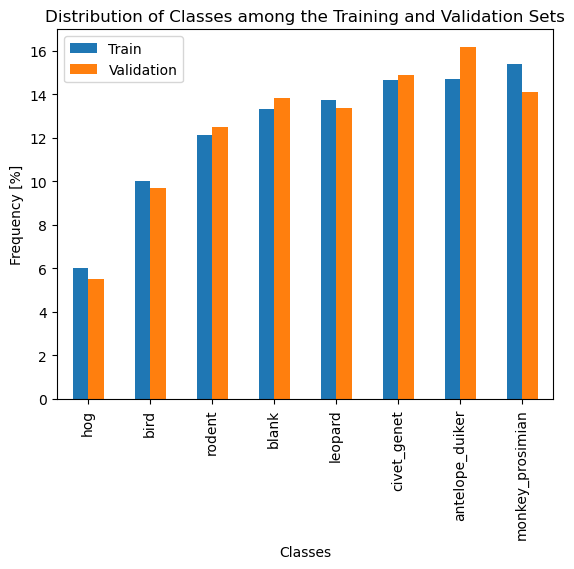

In [19]:
class_dist.sort_values(by= "Train").plot(kind= "bar")
plt.title("Distribution of Classes among the Training and Validation Sets")
plt.xlabel("Classes")
plt.ylabel("Frequency [%]")
plt.show()

The above figure shows that, with some variations, both training and validation sets exihibit similar distributions of classes, not identical.

Now form two dataloaders for training and validation sets. The training dataloader shuold be shuffled everytime we run it. The validation set would not be shuffled.

In [20]:
tr_loader = DataLoader(tr_set, batch_size= 32, shuffle= True)
val_loader = DataLoader(val_set, batch_size= 32)

In [21]:
# Check for one batch of training dataloader size
sing_batch = next(iter(tr_loader))[0]
print("Shape of one batch:", sing_batch.shape)

Shape of one batch: torch.Size([32, 3, 224, 224])


#### Multiclass Classiffication Model

Here we want a model to take an image as input and predicts what's in it (an animal or 'blank'). The model gives a confidence for each class, 8 values. Higher numbers mean that the model is more confident that class is the right answer. To find which one is the largest using `argmax`, from `torch`.

In the previous notebook, we developed shallow neural network, having a dense (fully connected) layers. It is a standard network that could be also used here. However, for better accuracy, more layers should be added, and that model would take much time to train.

The neural network architecture good for images is `CNN` 9Convolutional Neural Network. It has a sequence of convolutional, max pooling layers together with fully connected inner layers and an output layer. 

In [22]:
# Sequential model to track the layers of the CNN
model_1 = torch.nn.Sequential()

# The input layer: Convolution
conv1 = torch.nn.Conv2d(in_channels= 3, out_channels= 16, kernel_size= (3, 3), padding= 1)
model_1.append(conv1)

# Activation function
model_1.append(torch.nn.ReLU())

# Max pooling: to reduce the size (pixels) in each channel
max_pool1 = torch.nn.MaxPool2d(kernel_size= (2, 2), stride= 2)
model_1.append(max_pool1)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
)

Lets check what would be size of the output of this model for one batch.

In [23]:
sample_batch = next(iter(tr_loader))[0]
print("Shape of sample batch:", sample_batch.shape)

Shape of sample batch: torch.Size([32, 3, 224, 224])


In [24]:
out_1 = model_1(sample_batch)
print("Shape of output of the model:", out_1.shape)

Shape of output of the model: torch.Size([32, 16, 112, 112])


There, number of the channels is increased to 16 due to convolution, and the width and heght reduced by half by the max pooling.

Now, the full model will be build using different layers.

In [25]:
model = torch.nn.Sequential()

conv1 = torch.nn.Conv2d(in_channels= 3, out_channels= 16, kernel_size= (3, 3), padding= 1)
model.append(conv1)
model.append(torch.nn.ReLU())
max_pool1 = torch.nn.MaxPool2d(kernel_size= (2, 2), stride= 2)
model.append(max_pool1)

conv2 = torch.nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= (3, 3), padding= 1)
model.append(conv2)
model.append(torch.nn.ReLU())
max_pool2 = torch.nn.MaxPool2d(kernel_size= (2,2), stride= 2)
model.append(max_pool2)

conv3 = torch.nn.Conv2d(32, 64, 3, padding= 1)
model.append(conv3)
model.append(torch.nn.ReLU())
max_pool3 = torch.nn.MaxPool2d(2)
model.append(max_pool3)

model.append(torch.nn.Flatten())
model.append(torch.nn.Dropout())

lin1 = torch.nn.Linear(in_features= 50176, out_features= 500)
model.append(lin1)
model.append(torch.nn.ReLU())
model.append(torch.nn.Dropout())

out_layer = torch.nn.Linear(in_features= 500, out_features= 8)
model.append(out_layer)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

Let's check the model is correct.

In [26]:
summary(model, input_size= (32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 8]                   --
├─Conv2d: 1-1                            [32, 16, 224, 224]        448
├─ReLU: 1-2                              [32, 16, 224, 224]        --
├─MaxPool2d: 1-3                         [32, 16, 112, 112]        --
├─Conv2d: 1-4                            [32, 32, 112, 112]        4,640
├─ReLU: 1-5                              [32, 32, 112, 112]        --
├─MaxPool2d: 1-6                         [32, 32, 56, 56]          --
├─Conv2d: 1-7                            [32, 64, 56, 56]          18,496
├─ReLU: 1-8                              [32, 64, 56, 56]          --
├─MaxPool2d: 1-9                         [32, 64, 28, 28]          --
├─Flatten: 1-10                          [32, 50176]               --
├─Dropout: 1-11                          [32, 50176]               --
├─Linear: 1-12                           [32, 500]                 25,088,500

The model has more than 25 million parameters. Due to complex model architecture, it will take more time and space to train it.

As in the previous notebook, `cross entropy` is used as loss function.

In [27]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

Train the model for 8 epochs

In [28]:
train(model, optimizer, loss_fn, tr_loader, val_loader, epochs= 8)

Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 1.41, Validation Loss: 1.05, Validation accuracy = 0.61


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.90, Validation Loss: 0.73, Validation accuracy = 0.74


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.69, Validation Loss: 0.63, Validation accuracy = 0.77


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.53, Validation Loss: 0.55, Validation accuracy = 0.82


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.44, Validation Loss: 0.53, Validation accuracy = 0.83


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.37, Validation Loss: 0.51, Validation accuracy = 0.83


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.32, Validation Loss: 0.48, Validation accuracy = 0.84


Training:   0%|          | 0/413 [00:00<?, ?it/s]

Scoring:   0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.29, Validation Loss: 0.53, Validation accuracy = 0.84


In [29]:
probs = predict(model, val_loader)
preds = torch.argmax(probs, dim= 1)

Predicting:   0%|          | 0/104 [00:00<?, ?it/s]

In [30]:
preds

tensor([3, 5, 5,  ..., 1, 3, 5])

In order to see the performace of the model, lets examine the confusion matrix. First, we need the targets.

In [31]:
val_targs = []
for _, labels in tqdm(val_loader):
    val_targs.extend(labels.tolist())

val_targs[:5]

100%|██████████| 104/104 [00:25<00:00,  4.04it/s]


[3, 5, 5, 4, 3]

In [32]:
len(val_targs)

3297

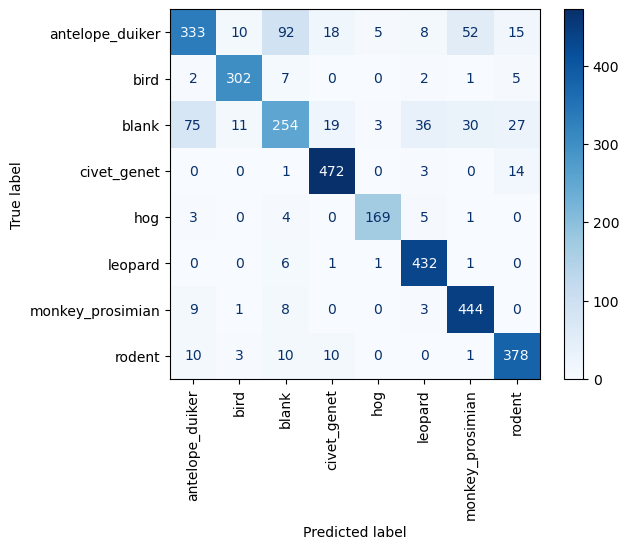

In [33]:
conf_mat = confusion_matrix(val_targs, preds)
conf_disp = ConfusionMatrixDisplay(confusion_matrix= conf_mat, display_labels= classes)
conf_disp.plot(cmap= plt.cm.Blues, xticks_rotation= "vertical")
plt.show()

From the confusion matrix, it can be seen that the model predicts some animals as blank images. Hence the model requires training with more epochs.

#### **Submission to Competition**

The competition requires to submit the confidence of each class for each image in the test folder.

In [ ]:
test_df = pd.read_csv("../data/animal images/test_features.csv")
test_df.head()

,id,filepath,site
0,ZJ016488,test_features/ZJ016488.jpg,S0082
1,ZJ016489,test_features/ZJ016489.jpg,S0040
2,ZJ016490,test_features/ZJ016490.jpg,S0040
3,ZJ016491,test_features/ZJ016491.jpg,S0041
4,ZJ016492,test_features/ZJ016492.jpg,S0040


In [36]:
sample_test_image_loc = test_df.iloc[0, 1]
sample_test_image_loc

'test_features/ZJ016488.jpg'

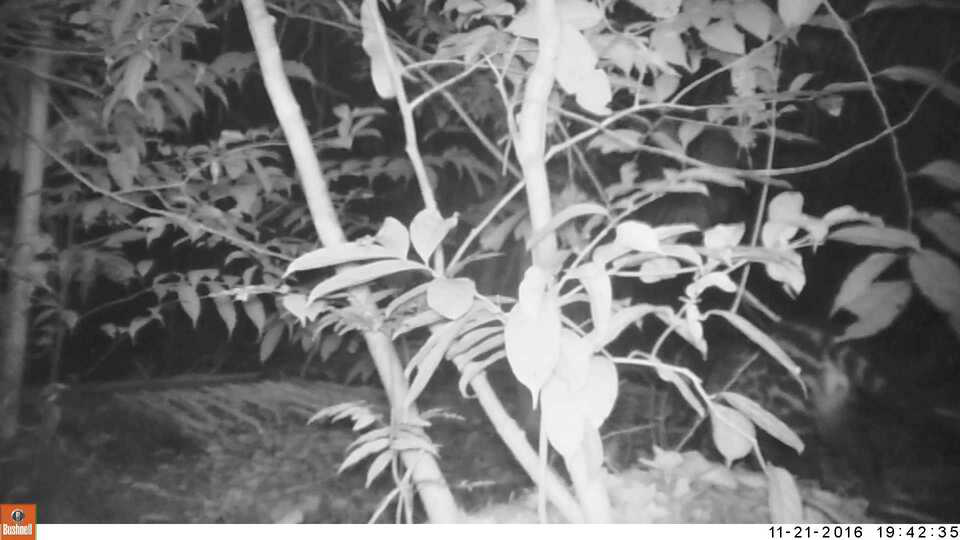

In [38]:
sample_test_image_path = os.path.join("../data", sample_test_image_loc)
sample_test_image = PIL.Image.open(sample_test_image_path)
sample_test_image

In [39]:
samp_test_image_trans = trans_norm(sample_test_image)
samp_test_image_trans.shape

torch.Size([3, 224, 224])

In [40]:
samp_image_probs = model(samp_test_image_trans.unsqueeze(0))
samp_image_probs

tensor([[ 1.0535, -2.9550,  1.8022,  1.2594, -7.9101, -6.3017, -0.2040,  0.9893]],
       grad_fn=<AddmmBackward0>)

These probabilities should be between $0$ and $1$. Hence we need to use `softmax` to get the confidences.

In [41]:
samp_image_conf = torch.nn.functional.softmax(samp_image_probs, dim= 1)
samp_image_conf

tensor([[1.7908e-01, 3.2523e-03, 3.7863e-01, 2.2002e-01, 2.2920e-05, 1.1448e-04,
         5.0927e-02, 1.6795e-01]], grad_fn=<SoftmaxBackward0>)

In [42]:
torch.argmax(samp_image_conf)

tensor(2)

In [43]:
test_conf_df = pd.DataFrame(samp_image_conf.tolist())
test_conf_df.columns = classes
test_conf_df.index = [test_df.iloc[0, 0]]
test_conf_df

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ016488,0.179082,0.003252,0.378627,0.220022,0.000023,0.000114,0.050927,0.167953


In [45]:
conf_df_list = []
for _, row in test_df.iterrows():
    id, path = row['id'], row['filepath']
    image = PIL.Image.open(os.path.join("../data", path))
    image_trans = trans_norm(image)
    image_unsqueezed = image_trans.unsqueeze(0)

    model.eval()
    with torch.no_grad():
        image_probs = model(image_unsqueezed)
        image_conf = torch.nn.functional.softmax(image_probs, dim= 1)

    image_out_df = pd.DataFrame(image_conf)
    image_out_df.columns = classes
    image_out_df.index = [id]

    conf_df_list.append(image_out_df)

test_conf_df_all = pd.concat(conf_df_list)
test_conf_df_all

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ016488,0.179082,0.003252,0.378627,2.200218e-01,0.000023,0.000114,0.050927,0.167953
ZJ016489,0.365368,0.038283,0.187654,3.505404e-03,0.008767,0.010256,0.373339,0.012827
ZJ016490,0.232628,0.000414,0.374184,2.991824e-01,0.030347,0.007331,0.015311,0.040603
ZJ016491,0.101806,0.000006,0.122579,1.867520e-06,0.000014,0.772622,0.002932,0.000038
ZJ016492,0.368439,0.200072,0.332889,1.227070e-03,0.000992,0.002078,0.090911,0.003392
...,...,...,...,...,...,...,...,...
ZJ020947,0.084341,0.001366,0.716584,2.284894e-04,0.002832,0.046117,0.147786,0.000746
ZJ020948,0.169791,0.002095,0.407423,7.047049e-05,0.000221,0.403253,0.013113,0.004033
ZJ020949,0.206336,0.004070,0.302670,4.577316e-01,0.001087,0.005707,0.001728,0.020670
ZJ020950,0.033224,0.007321,0.342897,5.198452e-03,0.000138,0.034680,0.564481,0.012062


Now save it as a csv.

In [ ]:
test_conf_df_all.to_csv("../data/animal images/submission.csv")

#### Saving the model

In [ ]:
torch.save(model, "../model/project_1/deepnet")

#### Conclusion

- The model is designed to work on images. That means it takes images as input in tensor and gives confidence for each class of animals and `blank`.

- CNN is used as it performs well on images and max pooling is utilized to reduce the size of pixels.

- Softmax is used to get the confidences for each class from the probabilities found from the model output.

- To get which animal is in the image or the image is blank, argmax from torch is used to find the maximum confidence and relate to the class.